!! THIS IS RUN WITH 10^4 chain members. TO GET A DECENT RUN, CHANGE THIS TO 10^6 !! BUT THAT TAKES TIME (~6 hours single core) !!

A very good introductory video on mcmc --> https://youtu.be/vTUwEu53uzs

An extremely crude implementation of MCMC (Metropolis) on Supernova data.

Here in this problem, we are trying to estimate h and $\Omega_m $ from Beysian inference based on SN data. For each supernova, we have the redshift, distance modulus $(\mu)$ and the associated error$(\sigma)$


In [1]:
import numpy as np
import pylab as plt
import time

basedir = "./"

In [2]:
NUM_ITER = int(1.0e+4)
h_chain = []
Om_chain = []

In [3]:
data = plt.genfromtxt("SN.dat.txt",names=True)
z_data = data["z"]
mu_data = data["mu"]
sigma_data = data["sigma"]
mu_th = np.zeros(len(mu_data))

data_strings = plt.genfromtxt("SN.dat.txt",dtype="string",usecols=(0,4),skip_header=1)
SN_name = data_strings[:,0]
quality_data = data_strings[:,1]

As instructed in the Problem Set, we assume a flat universe and Gaussian errors leading to a likelihood function given by 
$$ L \propto \mathrm{exp}\left[ -\frac{1}{2} \sum_{i=1}^n \frac{\left(\mu_i - \mu_{th}(z_i)\right)^2}{(\sigma_i)^2}\right]$$ 
where $$ \mu_{th} = 25 - 5log(h) + 5log(D_L^*)$$
Here, $D_L^* = D_L(h=1)$ and $D_L$ is given by
$$ D_L = 3000\,\,h^{-1}\,(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + 1 - \Omega_m}}\mathrm{Mpc}$$

Now, a full scale proper implmentation requires calculation of $D_L$ everytime the parameters are changed. However, as a quick and dirty way, (as suggested in the PSet), we are going to precalculate $D_L^*$ as a function of $\Omega_m$, and interpolate when we are running the chains. This is much faster than computing the integral each time. (and since this code is in Python, we need to be very careful about now slowing things down too much)

For ease of notation, let us write the above integral as follows:-
$$ D_L^* = (1+z)\,D(z)$$
where 
$$ D(z) = 3000\,\int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + 1 - \Omega_m}}$$

Now, to compute the first point in the interpolation for very small z, we assume $(1+z)^3 \sim 1$. Therefore 

$$ D_0 = D(z<<1) = 3000\,\,z_0$$

$$ D_{L0}^* = D_0\,(1+z_0)$$

For further points, we use the usual interpolation update rule, 
$$ D_{i+1} = D_i + 3000\, \frac{\Delta z}{\sqrt{ \Omega_m(1+z_{i+1})^3 + 1 - \Omega_m}} $$

$$ D_{L(i+1)}^* = D_{i+1}\,(1+z_{i+1})$$

In [4]:
z = np.linspace(0.001,2,2000)
delta_z = z[1]-z[0]
D = np.zeros(len(z))
DL = np.zeros(len(z))
mu = np.zeros(len(z))
#print delta_z,len(z)

In [5]:
D[0] = 3000*z[0] #D_0
DL[0] = D[0]*(1 + z[0]) #DL_0

h_chain.append(np.random.uniform())  #Initial guess for h   
Om_chain.append(np.random.uniform()) #Initial guess for Omega_m
h_step_width =  0.010 #SD of normal proposal distribution
Om_step_width =  0.030 #SD of normal proposal distribution

h_MAX = 1.0
h_MIN = 0.0
Om_MAX = 1.0
Om_MIN = 0.0

In [6]:
h_curr = h_chain[0]
Om_curr = Om_chain[0]
chi2_curr = 1.0e+10  # A high value to force the first acceptance
num_points = 0
chi_array = []  #for visually spotting burn-in

for i in range(0,NUM_ITER):
    
    h_trial = h_curr + np.random.normal(scale=h_step_width)   # We are using a Normal distribution for proposal
    Om_trial = Om_curr + np.random.normal(scale=Om_step_width)  # We are using a Normal distribution for proposal
    
    #effectively implementing a uninformed prior (misnomer!!)
    if  h_trial > h_MAX or h_trial < h_MIN or Om_trial > Om_MAX or Om_trial < Om_MIN:
        continue
    
    
    #calculating mu for 0 th redshift bin
    mu[0] = 25 - 5*np.log10(h_trial) + 5*np.log10(DL[0])
    
    #calculating mu for all other redshifts 
    for j in range(1,len(z)):
        D[j] = D[j-1] + 3000*(delta_z/(np.sqrt( Om_trial*(1+z[j])**3 + 1 - Om_trial )))
        DL[j] = D[j]*( 1 + z[j])
        mu[j] = 25 - 5*np.log10(h_trial) + 5*np.log10(DL[j])
        
    
    #parsing over the data and assigning corresponding theoretical mu
    for j, z_d in enumerate(z_data):
        idx = int(z_d/delta_z)   #unstable line!!! WIll fail for z=2.0; but no such thing here
        mu_th[j] = mu[idx]
        
    
    #calculating posterior for this trial
    chi2_trial = np.sum( ((mu_data - mu_th)/(sigma_data))**2 )
    
    #As we are just using a uniform distribution as a prior instead of doing the following steps, I just implmenet a continue
    #statement earlier
    #Like_trial = np.exp(-0.5*chi2_trial)
    #Pos = Like*prior
    
    ## Metropolis accept-reject step (in log likelihood terms as priors have already been taken into account)
    log_like_ratio = 0.5 * (chi2_curr - chi2_trial)
    log_a = np.min([0,log_like_ratio])    #a = min(1,like_ratio)
    
    if ( np.log(np.random.uniform()) < log_a ):
        chi2_curr = chi2_trial
        h_curr = h_trial
        Om_curr = Om_trial
        num_points += 1 
    
    
    h_chain.append(h_curr)
    Om_chain.append(Om_curr)
    chi_array.append(chi2_curr)
    
    #Progress Bar
    bar_width = 110
    b = bar_width * i / NUM_ITER
    l = bar_width - b
    print '\r' + u"\u2588" * b + '-' * l,
    

#Dump arrays to a file
save_file = open(basedir + "mcmc2.txt","w")
np.savetxt(save_file,np.column_stack((h_chain,Om_chain)),delimiter=" ",header="h Om",fmt="%e %.e")
save_file.close()
     
print "Acceptance Rate: " + str((num_points*100)/NUM_ITER) +"%"

█████████████████████████████████████████████████████████████████████████████████████████████████████████████-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Acceptance Rate: 30%


As noted in the code above, we assume uniform priors for both h and $\Omega_m$. Instead of calculating the posterior, I do to things, implement a simple continue statement and frame the metropolis rule in terms of log likelihood and not the posterior probability. This works because

$$ \mathcal{P} \propto \mathcal{L}\Pi $$

where $\mathcal{P},\mathcal{L},\Pi$ are the posterior, likelihood and prior respectively. Thus when looking at the ratio between two $\mathcal{P}$s, the priors cancel out. 

Note that this is only possbile because we are assuming a uniorm/uninformative prior. If we had chosen to a different kind of a prior, we would have to go in for a different kind of an interpretation! 

Now, we plot some results!! 

Text(0.5,1,u'Spotting the Burn in steps')

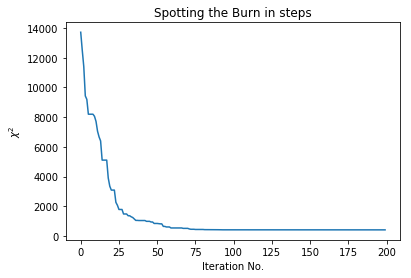

In [7]:
plt.plot(chi_array[:200])
plt.xlabel("Iteration No.")
plt.ylabel("$ \chi^2 $")
plt.title("Spotting the Burn in steps")

In [8]:
BURN_STEPS = 100

!!! SET THIS VARIABLE USING THE ABOVE PLOT!!!

Text(0.5,1,u'Path Taken by the walker')

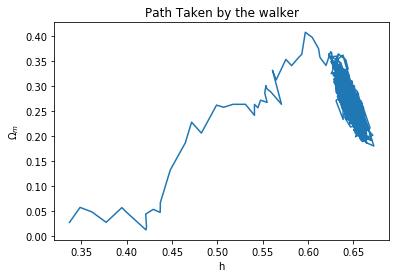

In [9]:
plt.plot(h_chain,Om_chain)
plt.xlabel("h")
plt.ylabel("$\Omega_m$")
plt.title("Path Taken by the walker")

Text(0.5,1,u'Path Without Most of the Burn-in steps')

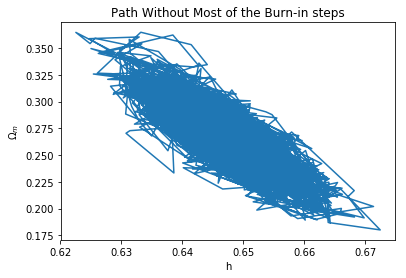

In [10]:
#Without the Burin in Steps

plt.plot(h_chain[BURN_STEPS:],Om_chain[BURN_STEPS:])
plt.xlabel("h")
plt.ylabel("$\Omega_m$")
plt.title("Path Without Most of the Burn-in steps")

Text(0.5,1,u'Distribution of h')

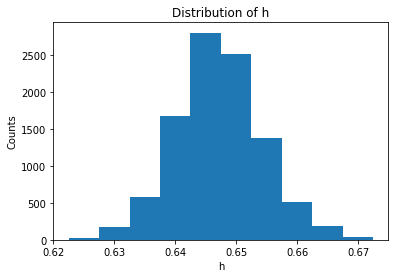

In [11]:
plt.hist(h_chain[BURN_STEPS:])
plt.xlabel("h")
plt.ylabel("Counts")
plt.title("Distribution of h")

Text(0.5,1,u'Distribution of $\\Omega_m$')

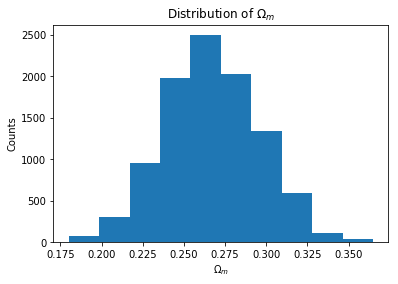

In [12]:
plt.hist(Om_chain[BURN_STEPS:])
plt.xlabel("$\Omega_m$")
plt.ylabel("Counts")
plt.title("Distribution of $\Omega_m$")

Text(0,0.5,u'$\\Omega_m$')

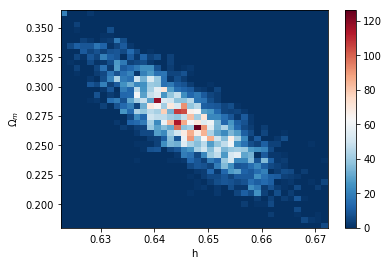

In [13]:
from matplotlib import cm as CM

Z, h_edges, Om_edges = np.histogram2d(h_chain[BURN_STEPS:], Om_chain[BURN_STEPS:], bins=40)
plt.pcolormesh(h_edges, Om_edges, Z, cmap=CM.RdBu_r)
plt.colorbar()
plt.xlabel("h")
plt.ylabel("$\Omega_m$")

Now, we use DFM's code to make a corner plot with the three standard contours. Note that sigma levels in 1D and 2D hisrograms are not the same!! 

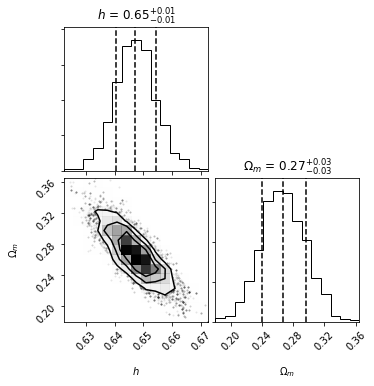

In [15]:
import corner

data_plot = np.array([h_chain[BURN_STEPS:], Om_chain[BURN_STEPS:]])
dp = data_plot.transpose()
figure = corner.corner(dp, labels=["$h$", "$\Omega_m$"],quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 12},bins=15)
